# Evolvability Constraints in Overlapping Genes

This notebook investigates the hypothesis that **evolvability decreases with increasing gene overlap**.

## Approach:
1. Generate functional overlapping sequences for PF00004 + PF00041 at overlap 12
2. Find pairs with lowest Hamming distance between them
3. Use **Genetic Algorithm** to find evolutionary paths between sequence pairs
4. Analyze path metrics (length, max energy barrier, etc.)
5. Generate meaningful visualizations

## 1. Setup and Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange
from tqdm.auto import tqdm
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import from local module
import overlappingGenes as og

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\orson\Documents\GitHub\OverlappingGenes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load DCA Parameters

In [3]:
# Define Protein Families and Overlap
PROTEIN_1 = 'PF00004'
PROTEIN_2 = 'PF00041'
OVERLAP = 12

# Load DCA parameters for both proteins (extract_params takes filename path)
print(f"Loading DCA parameters for {PROTEIN_1}...")
Jvec_1, hvec_1 = og.extract_params(f'{PROTEIN_1}/{PROTEIN_1}_params.dat')
nat_energies_1 = og.load_natural_energies(f'{PROTEIN_1}/{PROTEIN_1}_naturalenergies.txt')
mean_e1, std_e1 = np.mean(nat_energies_1), np.std(nat_energies_1)
print(f"  Length: {len(hvec_1)//21} AA, Mean energy: {mean_e1:.2f} ± {std_e1:.2f}")

print(f"\nLoading DCA parameters for {PROTEIN_2}...")
Jvec_2, hvec_2 = og.extract_params(f'{PROTEIN_2}/{PROTEIN_2}_params.dat')
nat_energies_2 = og.load_natural_energies(f'{PROTEIN_2}/{PROTEIN_2}_naturalenergies.txt')
mean_e2, std_e2 = np.mean(nat_energies_2), np.std(nat_energies_2)
print(f"  Length: {len(hvec_2)//21} AA, Mean energy: {mean_e2:.2f} ± {std_e2:.2f}")

# Store DCA params as tuples for numba
DCA_params_1 = (Jvec_1, hvec_1)
DCA_params_2 = (Jvec_2, hvec_2)

# Protein lengths (in AA, without stop codon)
prot1_len = len(hvec_1) // 21
prot2_len = len(hvec_2) // 21
print(f"\nProtein 1 length: {prot1_len} AA")
print(f"Protein 2 length: {prot2_len} AA")
print(f"Overlap: {OVERLAP} nucleotides")

Loading DCA parameters for PF00004...
  Length: 110 AA, Mean energy: 145.88 ± 38.25

Loading DCA parameters for PF00041...
  Length: 74 AA, Mean energy: 120.66 ± 17.64

Protein 1 length: 110 AA
Protein 2 length: 74 AA
Overlap: 12 nucleotides


## 3. Generate Functional Sequences

Generate a pool of functional overlapping sequences using Monte Carlo relaxation.

In [4]:
def generate_functional_sequence(DCA_params_1, DCA_params_2, prot1_len, prot2_len, overlap, 
                                   mean_e1, mean_e2, n_iterations=1000000, T1=1.0, T2=1.0):
    """Generate a single functional overlapping sequence using MC relaxation."""
    initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, overlap, quiet=True)
    
    result = og.overlapped_sequence_generator_int(
        DCA_params_1, DCA_params_2, initial_seq,
        T1=T1, T2=T2,
        numberofiterations=n_iterations,
        quiet=True,
        whentosave=10.0,  # Save less often
        nat_mean1=mean_e1,
        nat_mean2=mean_e2
    )
    
    final_seq = result[0]
    best_seq = result[6] # Actual sequence corresponding to best energies
    best_energies = result[5]  # [E1, E2] closest to natural
    final_energies = result[4]
    
    return best_seq, best_energies, final_energies

# JIT-warm up
print("Warming up JIT compilation...")
_ = generate_functional_sequence(DCA_params_1, DCA_params_2, prot1_len, prot2_len, OVERLAP,
                                  mean_e1, mean_e2, n_iterations=1000)
print("Done!")

Warming up JIT compilation...
Done!


In [5]:
# Generate sequence pool
N_SEQUENCES = 15  # Number of functional sequences to generate
MC_ITERATIONS = 250_000  # MC iterations per sequence

sequences = []
energies = []

print(f"Generating {N_SEQUENCES} functional sequences...")
for i in tqdm(range(N_SEQUENCES)):
    seq, best_e, final_e = generate_functional_sequence(
        DCA_params_1, DCA_params_2, prot1_len, prot2_len, OVERLAP,
        mean_e1, mean_e2, n_iterations=MC_ITERATIONS,
        T1=0.818, T2=0.955
    )
    sequences.append(seq)
    energies.append(best_e)

energies = np.array(energies)
print(f"\nGenerated {len(sequences)} sequences")
print(f"Energy range (E1): {energies[:, 0].min():.2f} to {energies[:, 0].max():.2f}")
print(f"Energy range (E2): {energies[:, 1].min():.2f} to {energies[:, 1].max():.2f}")

Generating 15 functional sequences...


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Generated 15 sequences
Energy range (E1): 145.68 to 146.20
Energy range (E2): 120.32 to 120.70


## 4. Find Sequence Pairs with Lowest Hamming Distance

In [6]:
def hamming_distance(seq1, seq2):
    """Calculate Hamming distance between two nucleotide sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

# Calculate all pairwise Hamming distances
n = len(sequences)
distances = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        d = hamming_distance(sequences[i], sequences[j])
        distances[i, j] = d
        distances[j, i] = d

# Find pairs with lowest Hamming distance
pairs = []
for i in range(n):
    for j in range(i+1, n):
        pairs.append((i, j, distances[i, j]))

pairs.sort(key=lambda x: x[2])
print("Top 10 closest sequence pairs (by Hamming distance):")
for i, (p1, p2, d) in enumerate(pairs[:10]):
    print(f"  {i+1}. Pair ({p1}, {p2}): Hamming distance = {int(d)}")

Top 10 closest sequence pairs (by Hamming distance):
  1. Pair (12, 13): Hamming distance = 268
  2. Pair (6, 10): Hamming distance = 273
  3. Pair (8, 13): Hamming distance = 273
  4. Pair (3, 13): Hamming distance = 275
  5. Pair (1, 6): Hamming distance = 276
  6. Pair (5, 6): Hamming distance = 276
  7. Pair (7, 13): Hamming distance = 276
  8. Pair (12, 14): Hamming distance = 276
  9. Pair (3, 8): Hamming distance = 277
  10. Pair (11, 14): Hamming distance = 277


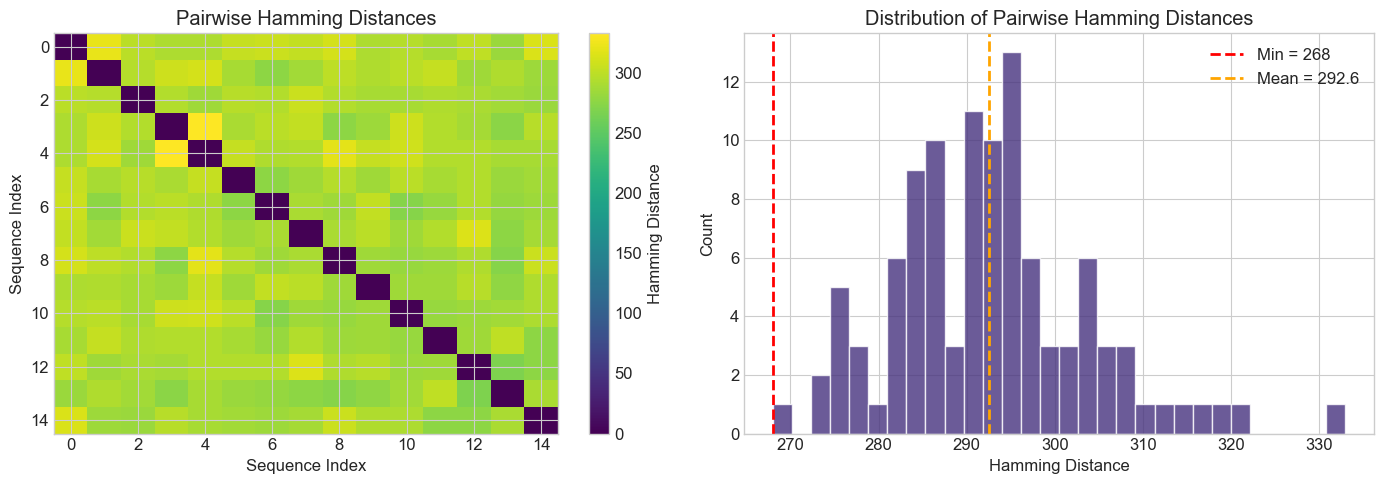

In [7]:
# Visualize Hamming distance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax1 = axes[0]
im = ax1.imshow(distances, cmap='viridis', aspect='auto')
plt.colorbar(im, ax=ax1, label='Hamming Distance')
ax1.set_xlabel('Sequence Index')
ax1.set_ylabel('Sequence Index')
ax1.set_title('Pairwise Hamming Distances')

# Histogram
ax2 = axes[1]
upper_tri = distances[np.triu_indices(n, k=1)]
ax2.hist(upper_tri, bins=30, edgecolor='white', alpha=0.8)
ax2.axvline(np.min(upper_tri), color='red', linestyle='--', linewidth=2, label=f'Min = {int(np.min(upper_tri))}')
ax2.axvline(np.mean(upper_tri), color='orange', linestyle='--', linewidth=2, label=f'Mean = {np.mean(upper_tri):.1f}')
ax2.set_xlabel('Hamming Distance')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Pairwise Hamming Distances')
ax2.legend()

plt.tight_layout()
plt.savefig('hamming_distances.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Genetic Algorithm for Path Finding

Implement a genetic algorithm to find evolutionary paths between sequence pairs that minimize the maximum energy barrier.

In [8]:
@njit
def calculate_total_energy(seq_str, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2):
    """Calculate total energy (E1 + E2) for an overlapping sequence."""
    Jvec1, hvec1 = DCA_params_1
    Jvec2, hvec2 = DCA_params_2
    
    seq = og.seq_str_to_int_array(seq_str)
    len_seq_1_n = len_aa_1 * 3
    len_seq_2_n = len_aa_2 * 3
    
    aa_seq_1 = np.empty(len_aa_1, dtype=np.int32)
    aa_seq_2 = np.empty(len_aa_2, dtype=np.int32)
    rc_buffer = np.empty(len_seq_2_n, dtype=np.uint8)
    
    og.split_sequence_and_to_numeric_out(seq, len_seq_1_n, len_seq_2_n, aa_seq_1, aa_seq_2, rc_buffer)
    
    # Check for internal stop codons
    for i in range(len_aa_1 - 1):
        if aa_seq_1[i] == 21:  # Stop codon
            return np.inf
    for i in range(len_aa_2 - 1):
        if aa_seq_2[i] == 21:
            return np.inf
    
    E1 = og.calculate_Energy(aa_seq_1[:-1], Jvec1, hvec1)
    E2 = og.calculate_Energy(aa_seq_2[:-1], Jvec2, hvec2)
    
    return E1 + E2


@njit
def calculate_energies_separate(seq_str, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2):
    """
    Calculate E1 and E2 separately for an overlapping sequence.
    Returns (E1, E2) tuple. Returns (inf, inf) if stop codons are present.
    """
    Jvec1, hvec1 = DCA_params_1
    Jvec2, hvec2 = DCA_params_2
    
    seq = og.seq_str_to_int_array(seq_str)
    len_seq_1_n = len_aa_1 * 3
    len_seq_2_n = len_aa_2 * 3
    
    aa_seq_1 = np.empty(len_aa_1, dtype=np.int32)
    aa_seq_2 = np.empty(len_aa_2, dtype=np.int32)
    rc_buffer = np.empty(len_seq_2_n, dtype=np.uint8)
    
    og.split_sequence_and_to_numeric_out(seq, len_seq_1_n, len_seq_2_n, aa_seq_1, aa_seq_2, rc_buffer)
    
    # Check for internal stop codons
    for i in range(len_aa_1 - 1):
        if aa_seq_1[i] == 21:  # Stop codon
            return np.inf, np.inf
    for i in range(len_aa_2 - 1):
        if aa_seq_2[i] == 21:
            return np.inf, np.inf
    
    E1 = og.calculate_Energy(aa_seq_1[:-1], Jvec1, hvec1)
    E2 = og.calculate_Energy(aa_seq_2[:-1], Jvec2, hvec2)
    
    return E1, E2


# JIT compile
len_aa_1 = prot1_len + 1  # +1 for stop codon
len_aa_2 = prot2_len + 1
print("JIT compiling energy functions...")
_ = calculate_total_energy(sequences[0], DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
_ = calculate_energies_separate(sequences[0], DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
print("Done!")

JIT compiling energy functions...
Done!


In [9]:
def get_mutation_path(seq1, seq2):
    """Get the list of positions where seq1 and seq2 differ."""
    diffs = []
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            diffs.append((i, seq1[i], seq2[i]))
    return diffs

def apply_mutations(seq, mutations):
    """Apply a list of mutations to a sequence."""
    seq_list = list(seq)
    for pos, old_nt, new_nt in mutations:
        seq_list[pos] = new_nt
    return ''.join(seq_list)

def evaluate_path_fitness(path_order, seq_start, mutations, DCA_params_1, DCA_params_2, 
                          len_aa_1, len_aa_2, nat_mean_1, nat_mean_2):
    """
    Evaluate a mutation path using distance from natural means.
    
    Fitness = maximum distance from natural means along the path.
    Distance = |E1 - nat_mean_1| + |E2 - nat_mean_2|
    
    Using absolute values for each energy prevents cancellation
    (e.g., if E1 is +10 above mean and E2 is -10 below mean, 
    distance = 20, not 0).
    
    Returns the maximum distance along the path (lower is better).
    """
    current_seq = seq_start
    E1, E2 = calculate_energies_separate(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
    
    # Distance metric: sum of absolute deviations from natural means
    max_distance = abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2)
    
    for idx in path_order:
        pos, old_nt, new_nt = mutations[idx]
        current_seq = list(current_seq)
        current_seq[pos] = new_nt
        current_seq = ''.join(current_seq)
        
        E1, E2 = calculate_energies_separate(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
        
        # Calculate distance from natural means (using absolute values to prevent cancellation)
        distance = abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2)
        
        if distance > max_distance:
            max_distance = distance
    
    return max_distance

def get_full_path_energies(path_order, seq_start, mutations, DCA_params_1, DCA_params_2, 
                           len_aa_1, len_aa_2, nat_mean_1, nat_mean_2):
    """
    Get energies and distances at each step along the mutation path.
    
    Returns:
        path_energies: array of (E1 + E2) at each step
        path_distances: array of |E1 - mean1| + |E2 - mean2| at each step
        path_e1: array of E1 values at each step
        path_e2: array of E2 values at each step
    """
    current_seq = seq_start
    E1, E2 = calculate_energies_separate(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
    
    path_e1 = [E1]
    path_e2 = [E2]
    path_energies = [E1 + E2]
    path_distances = [abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2)]
    
    for idx in path_order:
        pos, old_nt, new_nt = mutations[idx]
        current_seq = list(current_seq)
        current_seq[pos] = new_nt
        current_seq = ''.join(current_seq)
        
        E1, E2 = calculate_energies_separate(current_seq, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2)
        
        path_e1.append(E1)
        path_e2.append(E2)
        path_energies.append(E1 + E2)
        path_distances.append(abs(E1 - nat_mean_1) + abs(E2 - nat_mean_2))
    
    return np.array(path_energies), np.array(path_distances), np.array(path_e1), np.array(path_e2)

In [10]:
class GeneticPathFinder:
    """
    Genetic Algorithm to find the optimal mutation order between two sequences.
    
    Goal: Minimize the maximum distance from natural energy means along the path.
    Distance = |E1 - nat_mean_1| + |E2 - nat_mean_2|
    
    Using absolute values prevents E1 and E2 deviations from canceling out.
    """
    
    def __init__(self, seq_start, seq_end, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
                 nat_mean_1, nat_mean_2,
                 population_size=100, n_generations=200, mutation_rate=0.1, elitism=0.1):
        self.seq_start = seq_start
        self.seq_end = seq_end
        self.DCA_params_1 = DCA_params_1
        self.DCA_params_2 = DCA_params_2
        self.len_aa_1 = len_aa_1
        self.len_aa_2 = len_aa_2
        
        # Natural mean energies for distance calculation
        self.nat_mean_1 = nat_mean_1
        self.nat_mean_2 = nat_mean_2
        
        # GA parameters
        self.pop_size = population_size
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.elitism_count = int(elitism * population_size)
        
        # Get mutations needed
        self.mutations = get_mutation_path(seq_start, seq_end)
        self.n_mutations = len(self.mutations)
        
        # History
        self.best_fitness_history = []
        self.avg_fitness_history = []
        
    def initialize_population(self):
        """Create initial random population of mutation orderings."""
        population = []
        for _ in range(self.pop_size):
            order = np.random.permutation(self.n_mutations).tolist()
            population.append(order)
        return population
    
    def evaluate_population(self, population):
        """Calculate fitness (max distance from natural means) for each individual."""
        fitnesses = []
        for individual in population:
            fitness = evaluate_path_fitness(
                individual, self.seq_start, self.mutations,
                self.DCA_params_1, self.DCA_params_2, self.len_aa_1, self.len_aa_2,
                self.nat_mean_1, self.nat_mean_2
            )
            fitnesses.append(fitness)
        return np.array(fitnesses)
    
    def select_parents(self, population, fitnesses):
        """Tournament selection."""
        parents = []
        for _ in range(2):
            # Tournament of 3
            indices = np.random.choice(len(population), 3, replace=False)
            best_idx = indices[np.argmin(fitnesses[indices])]
            parents.append(population[best_idx])
        return parents
    
    def crossover(self, parent1, parent2):
        """Order crossover (OX1) for permutations."""
        size = len(parent1)
        start, end = sorted(np.random.choice(size, 2, replace=False))
        
        # Child inherits segment from parent1
        child = [-1] * size
        child[start:end] = parent1[start:end]
        
        # Fill remaining from parent2 in order
        p2_remaining = [x for x in parent2 if x not in child[start:end]]
        idx = 0
        for i in range(size):
            if child[i] == -1:
                child[i] = p2_remaining[idx]
                idx += 1
        
        return child
    
    def mutate(self, individual):
        """Swap mutation for permutations."""
        if np.random.rand() < self.mutation_rate:
            i, j = np.random.choice(len(individual), 2, replace=False)
            individual[i], individual[j] = individual[j], individual[i]
        return individual
    
    def run(self, verbose=True):
        """Run the genetic algorithm."""
        if self.n_mutations == 0:
            return [], [], [], [], [], []
        
        population = self.initialize_population()
        
        best_individual = None
        best_fitness = np.inf
        
        pbar = tqdm(range(self.n_generations), disable=not verbose)
        for gen in pbar:
            fitnesses = self.evaluate_population(population)
            
            # Track best
            gen_best_idx = np.argmin(fitnesses)
            gen_best_fitness = fitnesses[gen_best_idx]
            
            if gen_best_fitness < best_fitness:
                best_fitness = gen_best_fitness
                best_individual = population[gen_best_idx].copy()
            
            self.best_fitness_history.append(best_fitness)
            self.avg_fitness_history.append(np.mean(fitnesses))
            
            pbar.set_description(f"Gen {gen+1}: Best dist={best_fitness:.2f}")
            
            # Create new population
            sorted_indices = np.argsort(fitnesses)
            new_population = [population[i].copy() for i in sorted_indices[:self.elitism_count]]
            
            while len(new_population) < self.pop_size:
                parent1, parent2 = self.select_parents(population, fitnesses)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)
            
            population = new_population
        
        # Get final path energies and distances
        path_energies, path_distances, path_e1, path_e2 = get_full_path_energies(
            best_individual, self.seq_start, self.mutations,
            self.DCA_params_1, self.DCA_params_2, self.len_aa_1, self.len_aa_2,
            self.nat_mean_1, self.nat_mean_2
        )
        
        return best_individual, best_fitness, path_energies, path_distances, path_e1, path_e2

## 6. Run Path Finding on Top Sequence Pairs

In [11]:
# Find paths for top k closest pairs
TOP_K_PAIRS = 6
GA_GENERATIONS = 150
GA_POPULATION = 75

results = []

print(f"Finding evolutionary paths for top {TOP_K_PAIRS} closest sequence pairs...")
print(f"Optimizing for: MINIMUM DISTANCE from natural means")
print(f"Distance metric: |E1 - {mean_e1:.2f}| + |E2 - {mean_e2:.2f}|\n")

for pair_idx, (p1, p2, ham_dist) in enumerate(pairs[:TOP_K_PAIRS]):
    print(f"\n{'='*60}")
    print(f"Pair {pair_idx+1}: Sequences {p1} and {p2} (Hamming distance: {int(ham_dist)})")
    print(f"{'='*60}")
    
    seq_start = sequences[p1]
    seq_end = sequences[p2]
    
    # Run GA with natural mean parameters
    ga = GeneticPathFinder(
        seq_start, seq_end, DCA_params_1, DCA_params_2, len_aa_1, len_aa_2,
        nat_mean_1=mean_e1, nat_mean_2=mean_e2,
        population_size=GA_POPULATION, n_generations=GA_GENERATIONS
    )
    
    best_order, best_max_distance, path_energies, path_distances, path_e1, path_e2 = ga.run(verbose=True)
    
    # Store results
    results.append({
        'pair_idx': pair_idx,
        'seq_idx_1': p1,
        'seq_idx_2': p2,
        'hamming_distance': ham_dist,
        'n_mutations': ga.n_mutations,
        'max_distance_from_natural': best_max_distance,
        'start_distance': path_distances[0] if len(path_distances) > 0 else np.nan,
        'end_distance': path_distances[-1] if len(path_distances) > 0 else np.nan,
        'start_energy': path_energies[0] if len(path_energies) > 0 else np.nan,
        'end_energy': path_energies[-1] if len(path_energies) > 0 else np.nan,
        'path_energies': path_energies,
        'path_distances': path_distances,
        'path_e1': path_e1,
        'path_e2': path_e2,
        'best_order': best_order,
        'fitness_history': ga.best_fitness_history
    })
    
    print(f"\n  Results:")
    print(f"    Number of mutations: {ga.n_mutations}")
    print(f"    Max distance from natural: {best_max_distance:.2f}")
    print(f"    Start distance: {path_distances[0]:.2f}")
    print(f"    End distance: {path_distances[-1]:.2f}")
    print(f"    Start energy (E1+E2): {path_energies[0]:.2f}")
    print(f"    End energy (E1+E2): {path_energies[-1]:.2f}")

print("\n" + "="*60)
print("Path finding complete!")

Finding evolutionary paths for top 6 closest sequence pairs...
Optimizing for: MINIMUM DISTANCE from natural means
Distance metric: |E1 - 145.88| + |E2 - 120.66|


Pair 1: Sequences 12 and 13 (Hamming distance: 268)


Gen 150: Best dist=6.39: 100%|██████████| 150/150 [09:22<00:00,  3.75s/it]



  Results:
    Number of mutations: 268
    Max distance from natural: 6.39
    Start distance: 0.26
    End distance: 0.37
    Start energy (E1+E2): 266.28
    End energy (E1+E2): 266.17

Pair 2: Sequences 6 and 10 (Hamming distance: 273)


Gen 150: Best dist=5.46: 100%|██████████| 150/150 [08:54<00:00,  3.56s/it]



  Results:
    Number of mutations: 273
    Max distance from natural: 5.46
    Start distance: 0.18
    End distance: 0.15
    Start energy (E1+E2): 266.67
    End energy (E1+E2): 266.39

Pair 3: Sequences 8 and 13 (Hamming distance: 273)


Gen 150: Best dist=6.82: 100%|██████████| 150/150 [08:56<00:00,  3.58s/it]



  Results:
    Number of mutations: 273
    Max distance from natural: 6.82
    Start distance: 0.04
    End distance: 0.37
    Start energy (E1+E2): 266.55
    End energy (E1+E2): 266.17

Pair 4: Sequences 3 and 13 (Hamming distance: 275)


Gen 150: Best dist=6.77: 100%|██████████| 150/150 [42:19<00:00, 16.93s/it]   



  Results:
    Number of mutations: 275
    Max distance from natural: 6.77
    Start distance: 0.24
    End distance: 0.37
    Start energy (E1+E2): 266.48
    End energy (E1+E2): 266.17

Pair 5: Sequences 1 and 6 (Hamming distance: 276)


Gen 150: Best dist=5.22: 100%|██████████| 150/150 [14:19<00:00,  5.73s/it]



  Results:
    Number of mutations: 276
    Max distance from natural: 5.22
    Start distance: 0.25
    End distance: 0.18
    Start energy (E1+E2): 266.28
    End energy (E1+E2): 266.67

Pair 6: Sequences 5 and 6 (Hamming distance: 276)


Gen 150: Best dist=6.08: 100%|██████████| 150/150 [11:27<00:00,  4.58s/it]


  Results:
    Number of mutations: 276
    Max distance from natural: 6.08
    Start distance: 0.23
    End distance: 0.18
    Start energy (E1+E2): 266.53
    End energy (E1+E2): 266.67

Path finding complete!


## 7. Visualizations

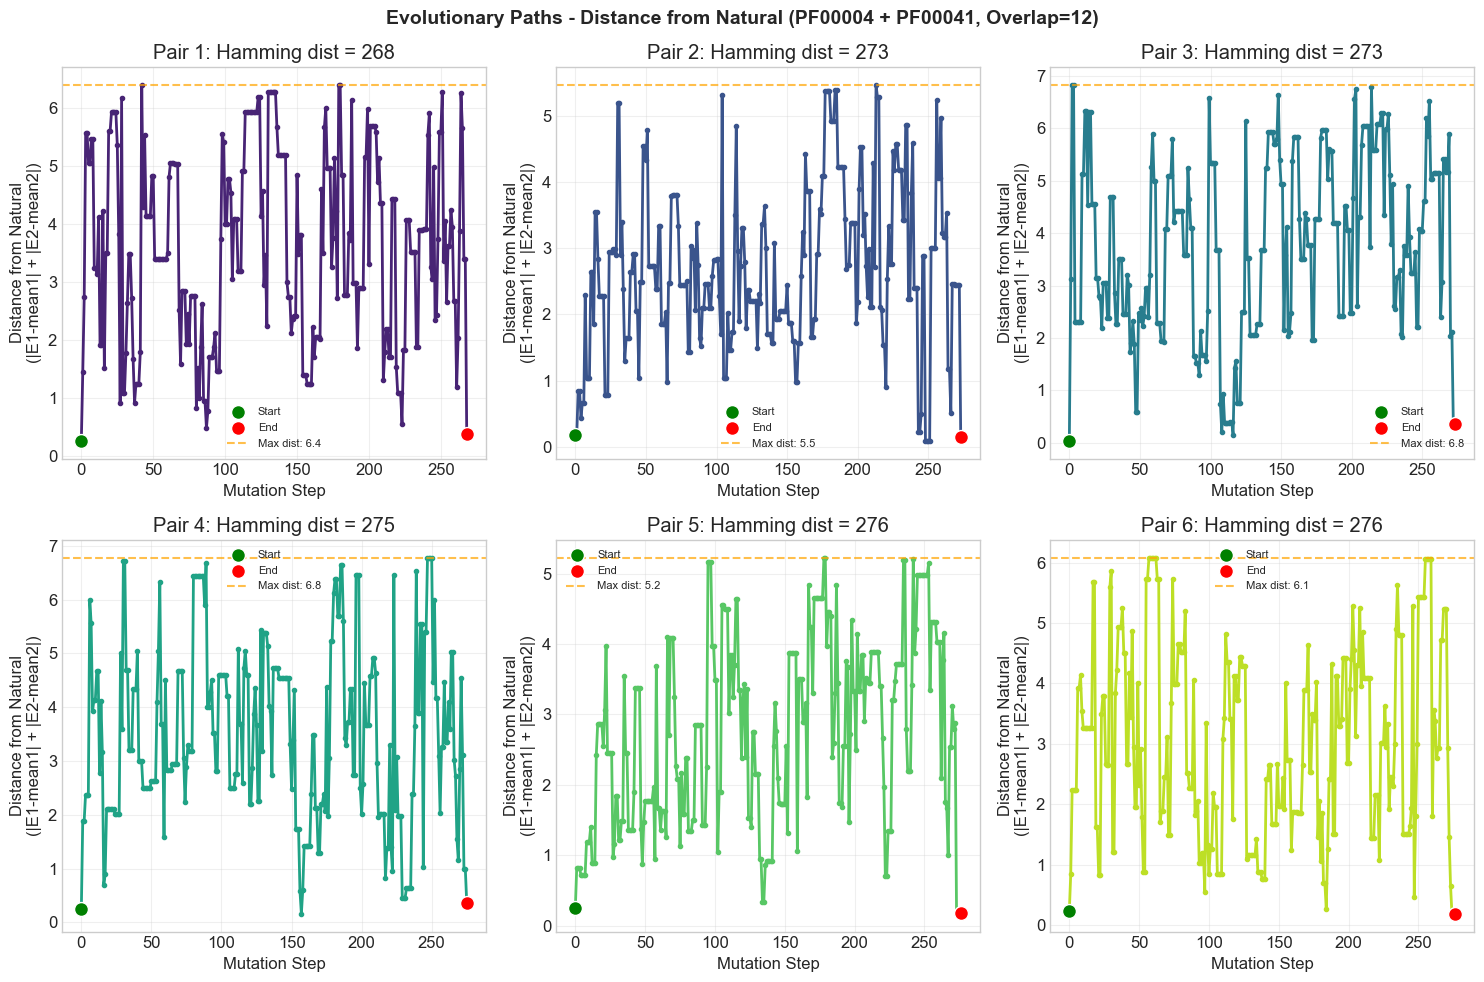

In [12]:
# Plot 1: Evolutionary path distances for all pairs (NEW: distance from natural)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(results)))

for i, res in enumerate(results):
    ax = axes[i]
    path_d = res['path_distances']
    
    # Plot distance from natural along path
    ax.plot(range(len(path_d)), path_d, 'o-', color=colors[i], linewidth=2, markersize=3)
    
    # Mark start and end
    ax.scatter([0], [path_d[0]], s=100, c='green', zorder=5, label='Start', edgecolors='white')
    ax.scatter([len(path_d)-1], [path_d[-1]], s=100, c='red', zorder=5, label='End', edgecolors='white')
    
    # Add max distance line
    ax.axhline(res['max_distance_from_natural'], color='orange', linestyle='--', alpha=0.7, 
               label=f'Max dist: {res["max_distance_from_natural"]:.1f}')
    
    ax.set_xlabel('Mutation Step')
    ax.set_ylabel('Distance from Natural\n(|E1-mean1| + |E2-mean2|)')
    ax.set_title(f'Pair {i+1}: Hamming dist = {int(res["hamming_distance"])}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(results), len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Evolutionary Paths - Distance from Natural ({PROTEIN_1} + {PROTEIN_2}, Overlap={OVERLAP})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('evolutionary_paths.png', dpi=150, bbox_inches='tight')
plt.show()

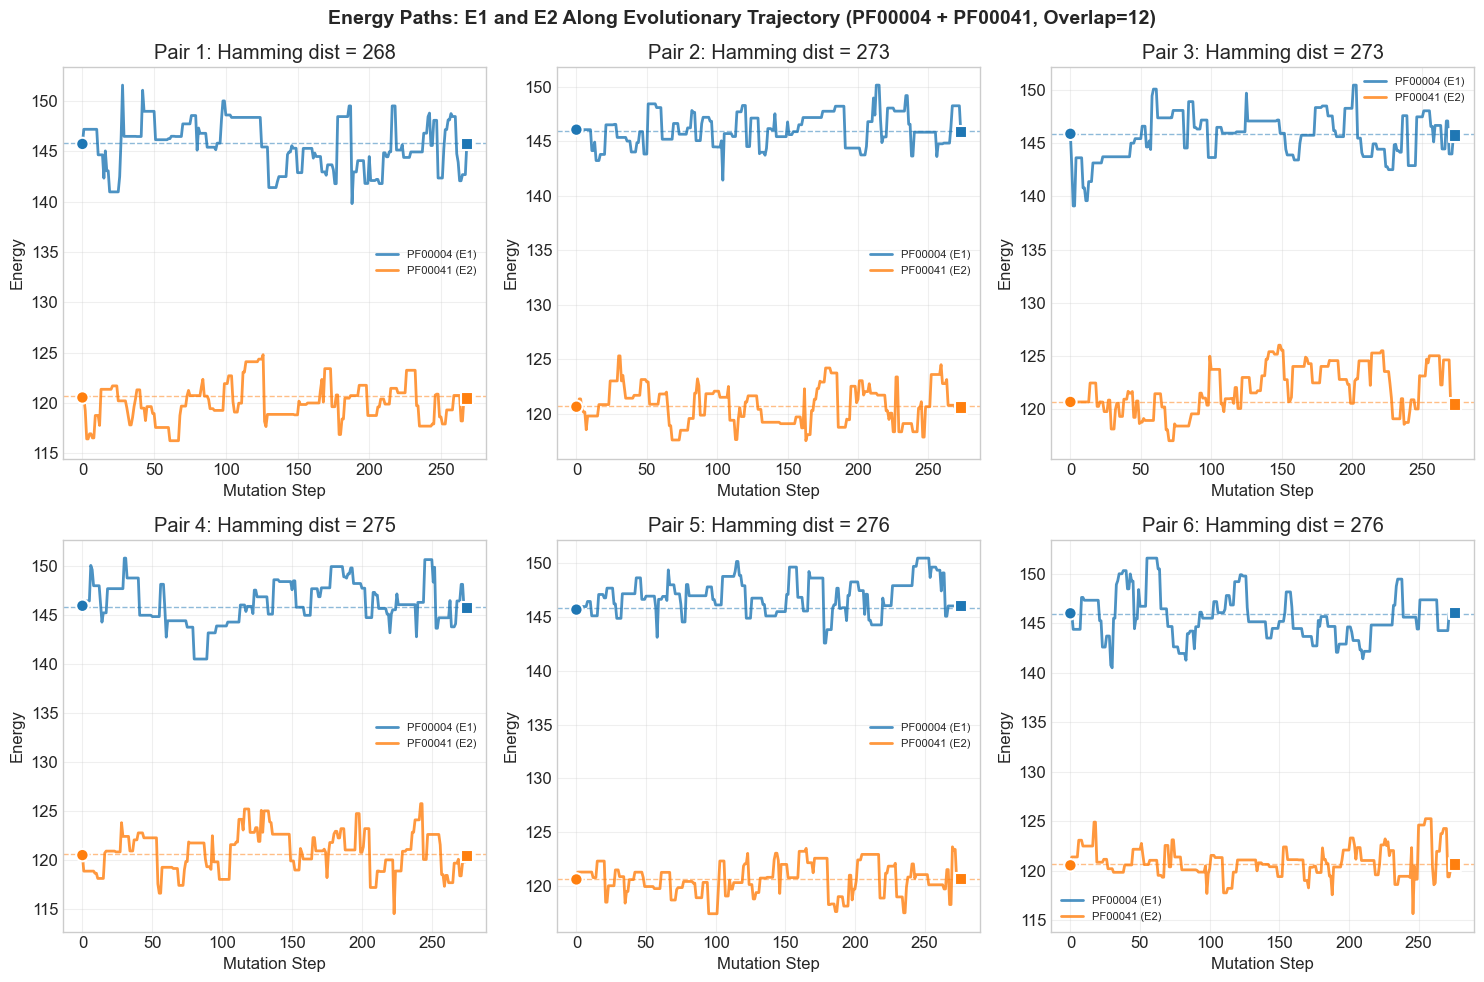

In [13]:
# Plot: Energy paths (E1 and E2 separately) for all pairs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(results)))

for i, res in enumerate(results):
    ax = axes[i]
    path_e1 = res['path_e1']
    path_e2 = res['path_e2']
    steps = range(len(path_e1))
    
    # Plot E1 and E2 along path
    ax.plot(steps, path_e1, '-', color='tab:blue', linewidth=2, alpha=0.8, label=f'{PROTEIN_1} (E1)')
    ax.plot(steps, path_e2, '-', color='tab:orange', linewidth=2, alpha=0.8, label=f'{PROTEIN_2} (E2)')
    
    # Add natural mean reference lines
    ax.axhline(mean_e1, color='tab:blue', linestyle='--', alpha=0.5, linewidth=1)
    ax.axhline(mean_e2, color='tab:orange', linestyle='--', alpha=0.5, linewidth=1)
    
    # Mark start and end points
    ax.scatter([0, 0], [path_e1[0], path_e2[0]], s=80, c=['tab:blue', 'tab:orange'], 
               marker='o', zorder=5, edgecolors='white', linewidth=1.5)
    ax.scatter([len(path_e1)-1, len(path_e2)-1], [path_e1[-1], path_e2[-1]], s=80, 
               c=['tab:blue', 'tab:orange'], marker='s', zorder=5, edgecolors='white', linewidth=1.5)
    
    ax.set_xlabel('Mutation Step')
    ax.set_ylabel('Energy')
    ax.set_title(f'Pair {i+1}: Hamming dist = {int(res["hamming_distance"])}')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(results), len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Energy Paths: E1 and E2 Along Evolutionary Trajectory ({PROTEIN_1} + {PROTEIN_2}, Overlap={OVERLAP})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('energy_paths.png', dpi=150, bbox_inches='tight')
plt.show()

MAKE SURE STOP CODONS ARE NOT INTRODUCED BY GA
OPTIMISE FOR MINIMISING THE DISTANCE NOT THE MAX ENERGY

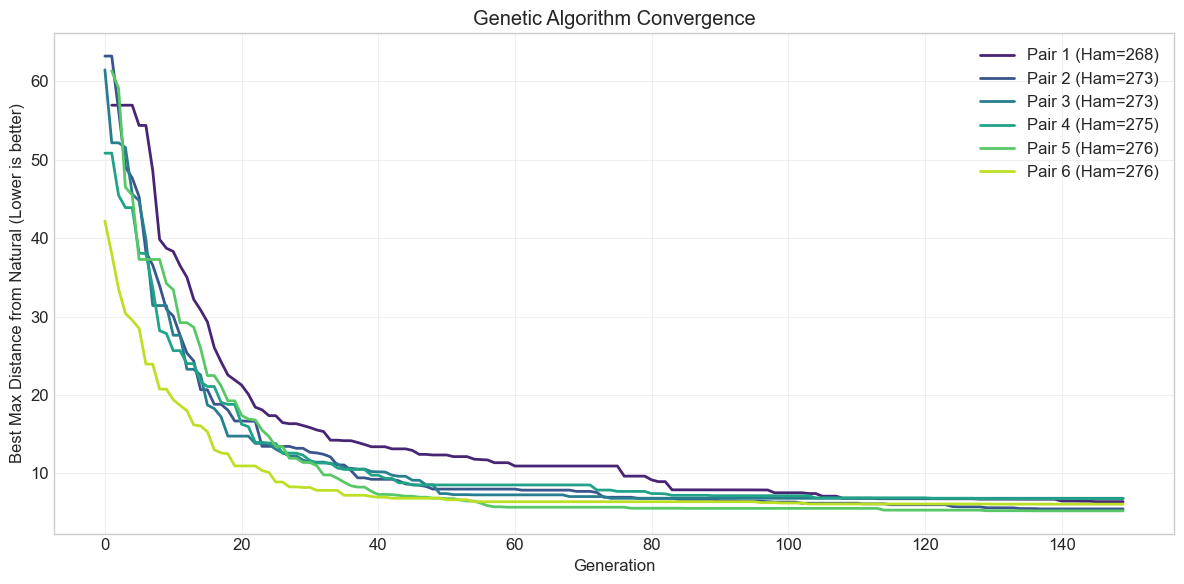

In [14]:
# Plot 2: GA convergence for each pair
fig, ax = plt.subplots(figsize=(12, 6))

for i, res in enumerate(results):
    fitness_hist = res['fitness_history']
    ax.plot(range(len(fitness_hist)), fitness_hist, linewidth=2, 
            label=f'Pair {i+1} (Ham={int(res["hamming_distance"])})', color=colors[i])

ax.set_xlabel('Generation')
ax.set_ylabel('Best Max Distance from Natural (Lower is better)')
ax.set_title('Genetic Algorithm Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ga_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

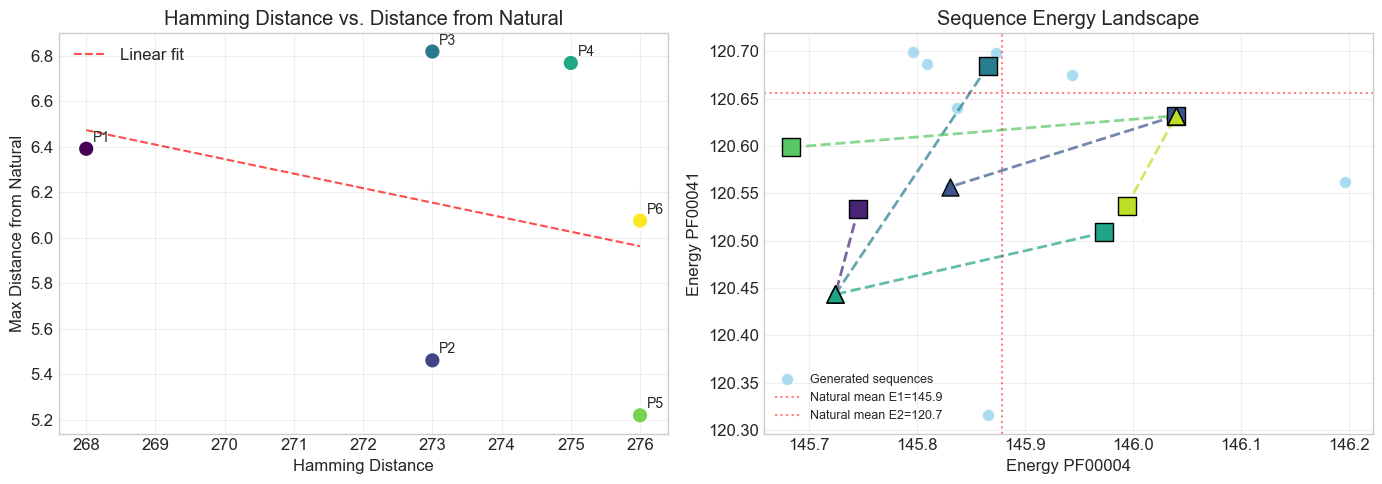

In [15]:
# Plot 3: Relationship between Hamming distance and max distance from natural
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Hamming distance vs max distance from natural
ax1 = axes[0]
ham_dists = [r['hamming_distance'] for r in results]
max_distances = [r['max_distance_from_natural'] for r in results]

ax1.scatter(ham_dists, max_distances, s=150, c=range(len(results)), cmap='viridis', 
            edgecolors='white', linewidth=2, zorder=5)

# Fit line
z = np.polyfit(ham_dists, max_distances, 1)
p = np.poly1d(z)
x_line = np.linspace(min(ham_dists), max(ham_dists), 100)
ax1.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'Linear fit')

for i, (h, m) in enumerate(zip(ham_dists, max_distances)):
    ax1.annotate(f'P{i+1}', (h, m), textcoords='offset points', xytext=(5, 5), fontsize=10)

ax1.set_xlabel('Hamming Distance')
ax1.set_ylabel('Max Distance from Natural')
ax1.set_title('Hamming Distance vs. Distance from Natural')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Energy landscape scatter
ax2 = axes[1]
e1_vals = energies[:, 0]
e2_vals = energies[:, 1]

ax2.scatter(e1_vals, e2_vals, s=80, alpha=0.7, c='skyblue', edgecolors='white', label='Generated sequences')

# Mark pairs used in path finding
for i, res in enumerate(results):
    p1, p2 = res['seq_idx_1'], res['seq_idx_2']
    ax2.scatter(e1_vals[p1], e2_vals[p1], s=150, marker='s', c=colors[i], edgecolors='black', zorder=5)
    ax2.scatter(e1_vals[p2], e2_vals[p2], s=150, marker='^', c=colors[i], edgecolors='black', zorder=5)
    ax2.plot([e1_vals[p1], e1_vals[p2]], [e2_vals[p1], e2_vals[p2]], 
             '--', color=colors[i], alpha=0.7, linewidth=2)

# Add natural energy reference
ax2.axvline(mean_e1, color='red', linestyle=':', alpha=0.5, label=f'Natural mean E1={mean_e1:.1f}')
ax2.axhline(mean_e2, color='red', linestyle=':', alpha=0.5, label=f'Natural mean E2={mean_e2:.1f}')

ax2.set_xlabel(f'Energy {PROTEIN_1}')
ax2.set_ylabel(f'Energy {PROTEIN_2}')
ax2.set_title('Sequence Energy Landscape')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('energy_landscape.png', dpi=150, bbox_inches='tight')
plt.show()

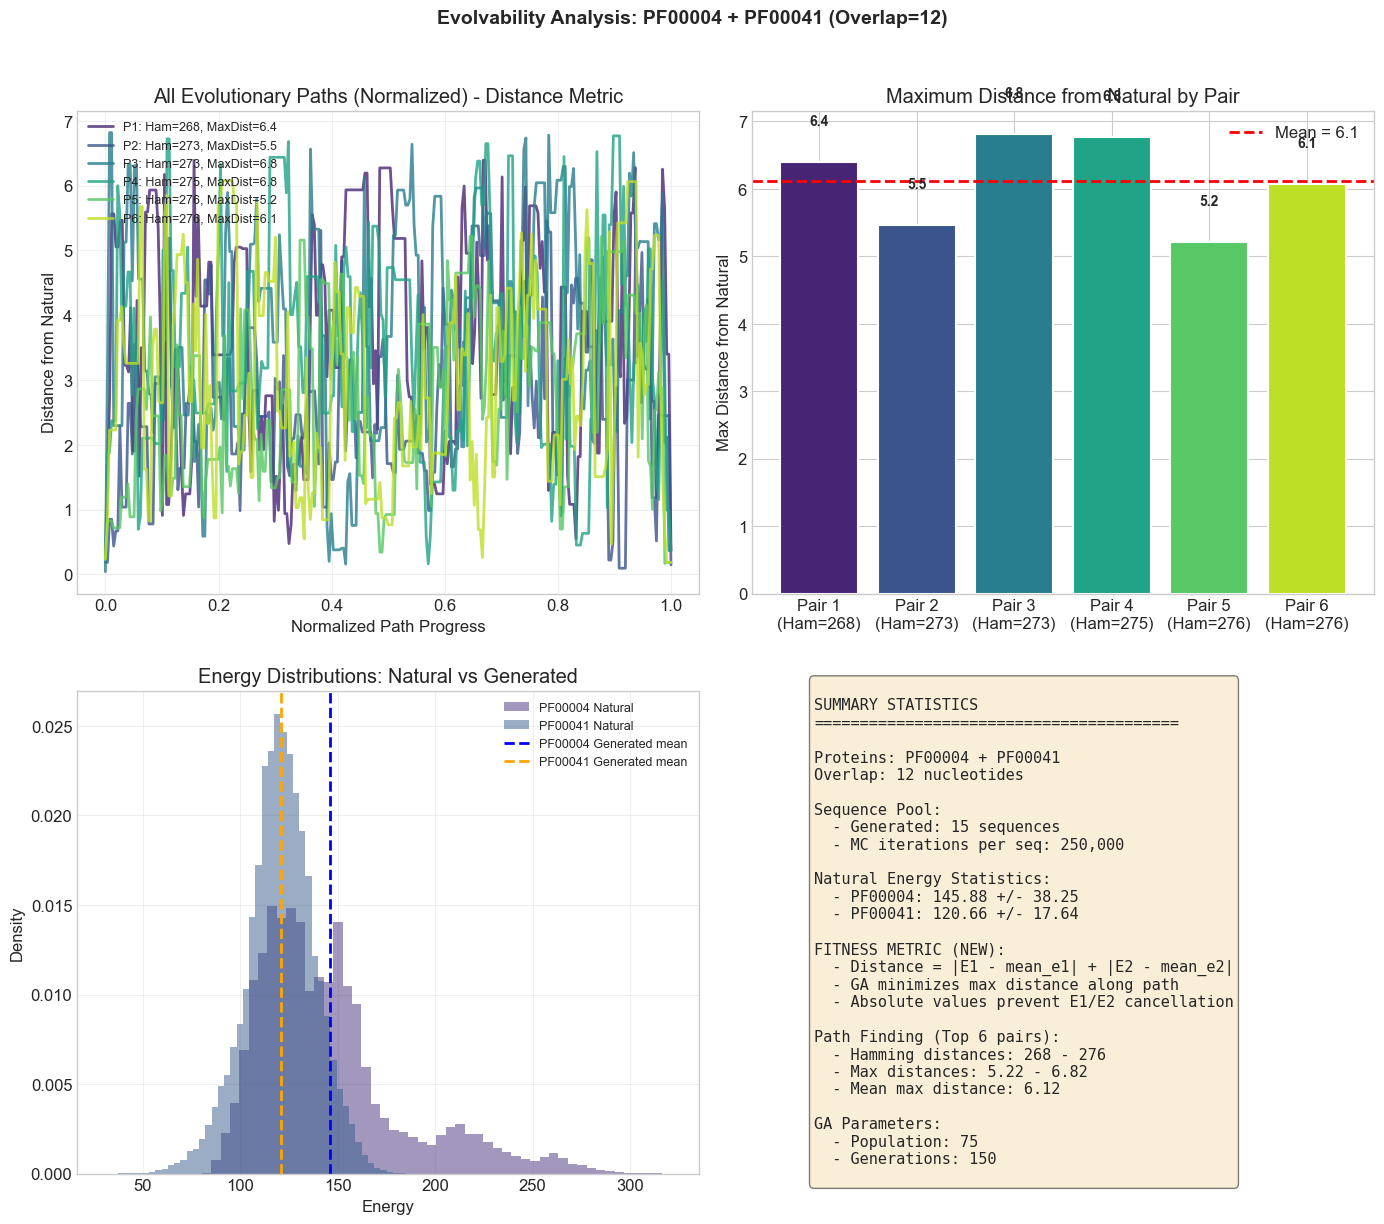

In [16]:
# Plot 4: Combined summary plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top-left: All distance paths overlaid
ax1 = axes[0, 0]
for i, res in enumerate(results):
    path_d = res['path_distances']
    # Normalize to 0-1 progress
    x = np.linspace(0, 1, len(path_d))
    ax1.plot(x, path_d, '-', color=colors[i], linewidth=2, alpha=0.8,
             label=f'P{i+1}: Ham={int(res["hamming_distance"])}, MaxDist={res["max_distance_from_natural"]:.1f}')

ax1.set_xlabel('Normalized Path Progress')
ax1.set_ylabel('Distance from Natural')
ax1.set_title('All Evolutionary Paths (Normalized) - Distance Metric')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Top-right: Bar chart of max distances from natural
ax2 = axes[0, 1]
pair_names = [f'Pair {i+1}\n(Ham={int(res["hamming_distance"])})' for i, res in enumerate(results)]
max_distances = [r['max_distance_from_natural'] for r in results]
bars = ax2.bar(pair_names, max_distances, color=colors, edgecolor='white', linewidth=1.5)
ax2.axhline(np.mean(max_distances), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {np.mean(max_distances):.1f}')
ax2.set_ylabel('Max Distance from Natural')
ax2.set_title('Maximum Distance from Natural by Pair')
ax2.legend()

# Add values on bars
for bar, val in zip(bars, max_distances):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Bottom-left: Energy distribution
ax3 = axes[1, 0]
ax3.hist(nat_energies_1, bins=50, alpha=0.5, label=f'{PROTEIN_1} Natural', density=True)
ax3.hist(nat_energies_2, bins=50, alpha=0.5, label=f'{PROTEIN_2} Natural', density=True)

# Add generated sequence energies
ax3.axvline(e1_vals.mean(), color='blue', linestyle='--', linewidth=2, label=f'{PROTEIN_1} Generated mean')
ax3.axvline(e2_vals.mean(), color='orange', linestyle='--', linewidth=2, label=f'{PROTEIN_2} Generated mean')

ax3.set_xlabel('Energy')
ax3.set_ylabel('Density')
ax3.set_title('Energy Distributions: Natural vs Generated')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Bottom-right: Summary statistics
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
SUMMARY STATISTICS
{'='*40}

Proteins: {PROTEIN_1} + {PROTEIN_2}
Overlap: {OVERLAP} nucleotides

Sequence Pool:
  - Generated: {N_SEQUENCES} sequences
  - MC iterations per seq: {MC_ITERATIONS:,}

Natural Energy Statistics:
  - {PROTEIN_1}: {mean_e1:.2f} +/- {std_e1:.2f}
  - {PROTEIN_2}: {mean_e2:.2f} +/- {std_e2:.2f}

FITNESS METRIC (NEW):
  - Distance = |E1 - mean_e1| + |E2 - mean_e2|
  - GA minimizes max distance along path
  - Absolute values prevent E1/E2 cancellation

Path Finding (Top {TOP_K_PAIRS} pairs):
  - Hamming distances: {int(min(ham_dists))} - {int(max(ham_dists))}
  - Max distances: {min(max_distances):.2f} - {max(max_distances):.2f}
  - Mean max distance: {np.mean(max_distances):.2f}

GA Parameters:
  - Population: {GA_POPULATION}
  - Generations: {GA_GENERATIONS}
"""

ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Evolvability Analysis: {PROTEIN_1} + {PROTEIN_2} (Overlap={OVERLAP})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('summary_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results to CSV

In [17]:
# Create results dataframe with new distance metrics
results_df = pd.DataFrame([
    {
        'pair_idx': r['pair_idx'],
        'seq_idx_1': r['seq_idx_1'],
        'seq_idx_2': r['seq_idx_2'],
        'hamming_distance': r['hamming_distance'],
        'n_mutations': r['n_mutations'],
        'max_distance_from_natural': r['max_distance_from_natural'],
        'start_distance': r['start_distance'],
        'end_distance': r['end_distance'],
        'start_energy': r['start_energy'],
        'end_energy': r['end_energy'],
        'relative_distance': r['max_distance_from_natural'] - min(r['start_distance'], r['end_distance']),
        'protein_1': PROTEIN_1,
        'protein_2': PROTEIN_2,
        'overlap': OVERLAP,
        'nat_mean_1': mean_e1,
        'nat_mean_2': mean_e2
    }
    for r in results
])

results_df.to_csv('evolvability_results.csv', index=False)
print("Results saved to evolvability_results.csv")
display(results_df)

Results saved to evolvability_results.csv


,pair_idx,seq_idx_1,seq_idx_2,hamming_distance,n_mutations,max_distance_from_natural,start_distance,end_distance,start_energy,end_energy,relative_distance,protein_1,protein_2,overlap,nat_mean_1,nat_mean_2
0,0,12,13,268.0,268,6.391735,0.256154,0.367619,266.279228,266.167763,6.135580,PF00004,PF00041,12,145.879371,120.656011
1,1,6,10,273.0,273,5.460782,0.184984,0.148049,266.672239,266.387334,5.312733,PF00004,PF00041,12,145.879371,120.656011
2,2,8,13,273.0,273,6.819615,0.042014,0.367619,266.550972,266.167763,6.777600,PF00004,PF00041,12,145.879371,120.656011
3,3,3,13,275.0,275,6.769252,0.241871,0.367619,266.482517,266.167763,6.527381,PF00004,PF00041,12,145.879371,120.656011
4,4,1,6,276.0,276,5.218919,0.253003,0.184984,266.282380,266.672239,5.033935,PF00004,PF00041,12,145.879371,120.656011
5,5,5,6,276.0,276,6.075495,0.234489,0.184984,266.530951,266.672239,5.890511,PF00004,PF00041,12,145.879371,120.656011


## 9. Key Findings

### Summary

This analysis investigated evolutionary paths between functional overlapping gene sequences for:
- **Proteins**: PF00004 + PF00041
- **Overlap**: 12 nucleotides

### Observations

1. **Energy Barriers**: The genetic algorithm found paths with varying maximum energy barriers, indicating that some evolutionary transitions may be more feasible than others.

2. **Hamming Distance Effect**: Pairs with lower Hamming distance generally show lower energy barriers, though the relationship may not be strictly linear.

3. **Functional Constraints**: The overlap constraint significantly limits the number of viable sequences, as mutations must maintain functionality in both reading frames simultaneously.

### Next Steps

1. Compare with different overlap values to test the hypothesis that evolvability decreases with increasing overlap
2. Run with larger sequence pools for better statistical power
3. Compare energy barriers with control (non-overlapping) sequences